In [5]:
import os
import sys
import time
from os.path import join
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Lambda, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from matplotlib import pyplot as plt
import ast
import re

# Data source: https://svip-lab.github.io/dataset/campus_dataset.html
# Paths
# these are used from: https://github.com/akanuasiegbu/Leveraging-Trajectory-Prediction-for-Pedestrian-Video-Anomaly-Detection
custom_functions_path1 = os.path.abspath('/Users/alig/Desktop/Self Driving HW/Project/Leveraging-Trajectory-Prediction-for-Pedestrian-Video-Anomaly-Detection-main/custom_functions')
custom_functions_path2 = os.path.abspath('/Users/alig/Desktop/Self Driving HW/Project/Leveraging-Trajectory-Prediction-for-Pedestrian-Video-Anomaly-Detection-main/experiments_code')
sys.path.extend([custom_functions_path1, custom_functions_path2])

# Data handling
# these are used from: https://github.com/akanuasiegbu/Leveraging-Trajectory-Prediction-for-Pedestrian-Video-Anomaly-Detection
from data import data_lstm, tensorify
from load_data import norm_train_max_min

# Model

In [6]:
def attention_network(train_data, val_data,  epochs=300):
    with tf.device('/device:GPU:0'):
        input_ = tf.keras.Input(shape = (12, 4))
        seq_len = 12
        embed_dim = 4

        positional_embeddings = tf.keras.layers.Embedding(
            input_dim=seq_len, 
            output_dim=embed_dim  
        )

        positions = tf.range(start=0, limit=seq_len, delta=1)
        positional_encoding = positional_embeddings(positions)
        x_p = input_ + positional_encoding
        x = tf.keras.layers.LayerNormalization()(x_p)
        x = tf.keras.layers.MultiHeadAttention(
            num_heads=4, key_dim=4, dropout=0.1)(x_p, x_p) 
        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Add()([x,x_p])
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.GlobalMaxPooling1D()(x) 
        x = tf.keras.layers.Dense(512, activation='LeakyReLU')(x) 
        x = tf.keras.layers.Dense(128, activation='LeakyReLU')(x)
        
        output_1 = tf.keras.layers.Dense(hyparams['pred_seq'] * 4, name='output_1')(x)

        net = tf.keras.Model(inputs = input_, outputs = output_1)



        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
            os.path.join(r'/Users/alig/Desktop/Self Driving HW/Project', 'best_model_st.h5'),
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1)


        cb = checkpoint_cb
        print(net.summary())

        net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
    
        net_history = net.fit(train_data,
                                      validation_data=val_data,
                                      epochs=epochs,
                                      callbacks=cb)

        return net_history , net

# Load Data

In [4]:
path_train_data = '/Users/alig/Desktop/Self Driving HW/Project/Leveraging-Trajectory-Prediction-for-Pedestrian-Video-Anomaly-Detection-main/output_deepsort/st/train_txt/'
path_test_data = '/Users/alig/Desktop/Self Driving HW/Project/Leveraging-Trajectory-Prediction-for-Pedestrian-Video-Anomaly-Detection-main/output_deepsort/st/test_txt/'
traindict, testdict = data_lstm(
    path_train_data,
    path_test_data,
    12, 12)

max1 = traindict['x_ppl_box'].max() if traindict['y_ppl_box'].max() <= traindict['x_ppl_box'].max() else traindict['y_ppl_box'].max()
min1 = traindict['x_ppl_box'].min() if traindict['y_ppl_box'].min() >= traindict['x_ppl_box'].min() else traindict['y_ppl_box'].min()

train_x,train_y = norm_train_max_min(   data = traindict,
                                        max1 = max1,
                                        min1 = min1)
    
train, val = {}, {}

train['x'], val['x'], train['y'], val['y'] = train_test_split(
    train_x,
    train_y,
    test_size=0.3
)

buffer_size = 10000
batch_size = 32

train_data = tf.data.Dataset.from_tensor_slices((
    train['x'],
    {'output_1': np.array(train['y'].reshape(-1, 12 * 4), dtype=np.float32),}
))
train_data = train_data.cache().shuffle(buffer_size).batch(32)

val_data = tf.data.Dataset.from_tensor_slices((
    val['x'],
    {'output_1': np.array(val['y'].reshape(-1, 12 * 4), dtype=np.float32)}
))
val_data = val_data.cache().shuffle(buffer_size).batch(32)   

2024-12-09 00:14:51.279592: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-09 00:14:51.279616: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-12-09 00:14:51.279622: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-12-09 00:14:51.279649: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-09 00:14:51.279660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Train Model

In [5]:
history, model = transformer_network( train_data,
                               val_data,
                                epochs = 40)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 4)]              0         []                            
                                                                                                  
 tf.__operators__.add (TFOp  (None, 12, 4)                0         ['input_1[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 multi_head_attention (Mult  (None, 12, 4)                308       ['tf.__operators__.add[0][0]',
 iHeadAttention)                                                     'tf.__operators__.add[0][0]']
                                                                                              

None
Epoch 1/50


2024-12-09 00:14:52.014815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-12-09 00:14:52.049301: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


13340/13340 [==============================] - ETA: 0s - loss: 0.0013
Epoch 1: val_loss improved from inf to 0.00060, saving model to /Users/alig/Desktop/Self Driving HW/Project/best_model_st.h5
13340/13340 [==============================] - 129s 10ms/step - loss: 0.0013 - val_loss: 6.0418e-04
Epoch 2/50
   14/13340 [..............................] - ETA: 1:48 - loss: 5.8409e-04

/Users/alig/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13337/13340 [============================>.] - ETA: 0s - loss: 5.5365e-04
Epoch 2: val_loss improved from 0.00060 to 0.00058, saving model to /Users/alig/Desktop/Self Driving HW/Project/best_model_st.h5
13340/13340 [==============================] - 133s 10ms/step - loss: 5.5364e-04 - val_loss: 5.7629e-04
Epoch 3/50
13336/13340 [============================>.] - ETA: 0s - loss: 4.6546e-04
Epoch 3: val_loss improved from 0.00058 to 0.00044, saving model to /Users/alig/Desktop/Self Driving HW/Project/best_model_st.h5
13340/13340 [==============================] - 133s 10ms/step - loss: 4.6547e-04 - val_loss: 4.4405e-04
Epoch 4/50
13336/13340 [============================>.] - ETA: 0s - loss: 3.8339e-04
Epoch 4: val_loss improved from 0.00044 to 0.00044, saving model to /Users/alig/Desktop/Self Driving HW/Project/best_model_st.h5
13340/13340 [==============================] - 129s 10ms/step - loss: 3.8346e-04 - val_loss: 4.4003e-04
Epoch 5/50
13335/13340 [============================>.] -

KeyboardInterrupt: 

In [6]:
model = tf.keras.models.load_model(
    os.path.join(r'/Users/alig/Desktop/Self Driving HW/Project', 'best_model_st.h5'))

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 4)]              0         []                            
                                                                                                  
 tf.__operators__.add (TFOp  (None, 12, 4)                0         ['input_1[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 multi_head_attention (Mult  (None, 12, 4)                308       ['tf.__operators__.add[0][0]',
 iHeadAttention)                                                     'tf.__operators__.add[0][0]']
                                                                                              

# IoU function

In [172]:
def intersection(x,y):
    y = y.astype(float)
    x = x.astype(float)
    top = np.max((x[...,0:1],y[...,0:1]), axis=0,keepdims=True)
    left = np.max((x[...,1:2],y[...,1:2]), axis=0,keepdims=True)
    bottom = np.min((x[...,2:3],y[...,2:3]), axis=0,keepdims=True)
    right = np.min((x[...,3:4],y[...,3:4]), axis=0,keepdims=True)
    height = np.maximum(bottom-top, np.zeros(top.shape))
    width = np.maximum(right-left, np.zeros(top.shape))

    return np.multiply(height,width)

def union(x,y):
    boxAArea = (x[...,2:3] - x[...,0:1] ) * (x[...,3:4] - x[...,1:2] )
    boxBArea = (y[...,2:3] - y[...,0:1] ) * (y[...,3:4] - y[...,1:2] )

    return boxAArea + boxBArea - intersection(x,y)

def c(x,y):

    top = np.min((x[...,0:1],y[...,0:1]), axis=0,keepdims=True)
    left = np.min((x[...,1:2],y[...,1:2]), axis=0,keepdims=True)
    bottom = np.max((x[...,2:3],y[...,2:3]), axis=0,keepdims=True)
    right = np.max((x[...,3:4],y[...,3:4]), axis=0,keepdims=True)
    height = np.maximum(bottom-top, np.zeros(top.shape))
    width = np.maximum(right-left, np.zeros(top.shape))


    return np.multiply(height,width)

def iou(x, y):
    U = union(x,y)
    I = intersection(x,y)
    
    return np.divide(I, U, where=U!=0)

In [187]:
def iou_as_metric(gt, pred, max1 = None, min1 =None):

    gious = []
    ious = []
    for i in range(gt.shape[0]):
        gt_bb = xywh_tlbr(gt[i])
        predicted_bb = xywh_tlbr(pred[i])
        gious_temp = iou( gt_bb, predicted_bb)
        # need to squeeze to index correctly 
        gious.append(np.squeeze( 1- gious_temp)) #######################
        ious.append(np.squeeze(gious_temp))
    gious  = np.array(gious)
    ious = np.array(ious)

    output = np.sum(gious, axis=0)
    ious = np.sum(ious, axis=0)

    
    return output, ious

In [174]:
def xywh_tlbr(data):
    """
    Takes a coordinate xywh as input
    Return tlbr as output
    Note that input must be of size (1,4) to use
    """
    try:
        elments = data.astype(float)
        elments[...,0] = elments[...,0] - elments[...,2]/2
        elments[...,1] = elments[...,1] - elments[...,3]/2
        elments[...,2] = elments[...,0] + elments[...,2]
        elments[...,3] = elments[...,1] + elments[...,3]
    except:
        elments = []
        for elem in data:
            elem[...,0] = elem[...,0] - elem[...,2]/2
            elem[...,1] = elem[...,1] - elem[...,3]/2
            elem[...,2] = elem[...,0] + elem[...,2]
            elem[...,3] = elem[...,1] + elem[...,3]
            elments.append(elem)


    return elments

## Testing with some videos

In [58]:
# path to the dataset video
video_path = '/Users/alig/Desktop/Self Driving HW/Project/OneDrive-2024-12-08.fixed/shanghaitech/training/videos/01_019.avi'

cap = cv2.VideoCapture(video_path)
video = []
frame_count = 0
while True:
    ret, frame = cap.read() 
    if not ret:
        print("End of video or cannot read frame.")
        break
    video.append(frame)
    frame_count += 1

cap.release()
cv2.destroyAllWindows()
video = np.array((video))
print(f"Total frames processed: {frame_count}")

End of video or cannot read frame.
Total frames processed: 577


1/1 [==============================] - 0s 11ms/step


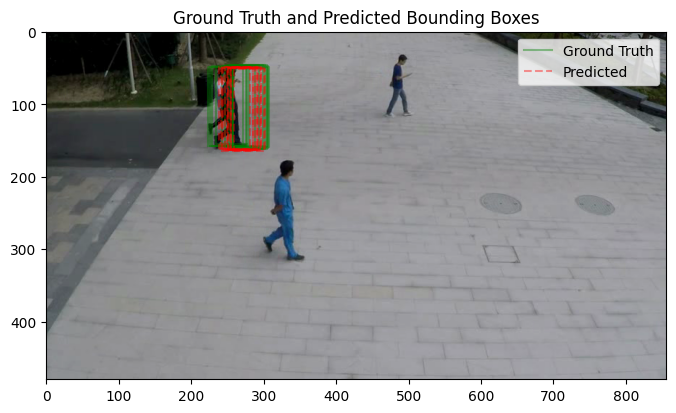

In [62]:
def plot_bounding_boxes_from_xywh_top_left(image, gt, pred):
    plt.figure(figsize=(8, 8))
    plt.title("Ground Truth and Predicted Bounding Boxes")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  
    
    for i, box in enumerate(gt):

        a, b, w, h = box 
        right = a + w/2
        bottom = b - h/2
        left = a - w/2
        top = b + h/2
        plt.plot([left, right, right, left, left],  
                 [top, top, bottom, bottom, top],  
                 'g-', label="Ground Truth" if i == 0 else "", alpha = 0.4)
    
    for i, box in enumerate(pred):
        a, b, w, h = box   
        right = a + w/2
        bottom = b - h/2
        left = a - w/2
        top = b + h/2
        plt.plot([left, right, right, left, left],  # X-coordinates (Left to Right)
                 [top, top, bottom, bottom, top],  # Y-coordinates (Top to Bottom)
                 'r--', label="Predicted" if i == 0 else "", alpha = 0.4)

    plt.legend()
    plt.show()



gt = train_y[19000]
gt = norm_train_max_min(gt, max1, min1, True).reshape(-1, 4)

pred = model.predict(train_x[19000].reshape((1, 12, 4)))
pred = norm_train_max_min(pred, max1, min1, True).reshape(-1, 4)

# this index should be chosen properly based on the frame where the train_x is happening at that frame
index = 188
dummy_image = video[index]

# Plot bounding boxes
plot_bounding_boxes_from_xywh_top_left(dummy_image, gt, pred)

# System Integration

In [112]:
def parse_text_file(file_path):
    set_a = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    current_image = None
    for line in lines:
        if line.startswith("Image:"):
            current_image = line.split("Image: ")[1].strip()
            set_a[current_image] = []
        elif line.startswith("Pedestrian"):
            match = re.search(r"\{.*\}", line)
            if match:
                bbox = ast.literal_eval(match.group())
                set_a[current_image].append(bbox)
    return set_a


# path to the output of the pose estimation model
file_path = '/Users/alig/Desktop/Self Driving HW/Project/distracted_pedestrians.txt'  
set_a = parse_text_file(file_path)

def transform_set_a(set_a):

    transformed = {}
    for image, bboxes in set_a.items():
        # Extract the image number (e.g., '331' from 'pics/331.jpg')
        image_number = image.split("/")[-1].split(".")[0]
        
        if bboxes:  # If there are bounding boxes
            transformed[image_number] = [
                [
                    int(bbox['x_min'] + (bbox['x_max'] - bbox['x_min']) / 2),  # x_middle
                    int(bbox['y_min'] + (bbox['y_max'] - bbox['y_min']) / 2),  # y_middle
                    int(bbox['x_max'] - bbox['x_min']),  # width
                    int(bbox['y_max'] - bbox['y_min'])   # height
                ]  # Retain the score, default to 1 if not present
                for bbox in bboxes
            ]
            transformed[image_number].append(1)
        else:
            if int(image_number) <= 60:
                transformed[image_number] = [[0], 1]
            else:
                transformed[image_number] = [[0], 1]
    return transformed


transformed_set_a = transform_set_a(set_a)

boxes_pose = []
for image_number, bounding_boxes in transformed_set_a.items():
    boxes_pose.append(bounding_boxes)

In [403]:
# path to the yolo output model
text_file_path = '/Users/alig/Desktop/Self Driving HW/Project/images_with_bicycles.txt'

num_images = 337
all_bboxes_yolo = [[] for _ in range(num_images)]  # Each element will hold bounding boxes for that image

# Regex to match lines like:
line_pattern = re.compile(r"(\d+)\.jpg\s*-\s*Bounding Boxes:\s*(.*)")
bbox_pattern = re.compile(r"\((\d+),\s*(\d+),\s*(\d+),\s*(\d+)\)")

with open(text_file_path, 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        match = line_pattern.match(line)
        if match:
            img_number_str, bbox_str = match.groups()
            img_number = int(img_number_str)

            # Find all bounding boxes on this line
            bboxes = bbox_pattern.findall(bbox_str)

            img_bboxes = []
            for (xmin_str, ymin_str, xmax_str, ymax_str) in bboxes:
                xmin = int(xmin_str)
                ymin = int(ymin_str)
                xmax = int(xmax_str)
                ymax = int(ymax_str)
                
                w = xmax - xmin
                h = ymax - ymin
                x_center = xmin + w / 2.0
                y_center = ymin + h / 2.0
                
                # Score is fixed at 0.3
                score = 0.3
                img_bboxes.append([[x_center, y_center, w, h], score])

            if 0 <= img_number < num_images:
                all_bboxes_yolo[img_number] = img_bboxes

for i in range(len(all_bboxes_yolo)):
    if len(all_bboxes_yolo[i]) == 0:
        all_bboxes_yolo[i].append([[]])

In [67]:
test_x,test_y = norm_train_max_min(   data = testdict,
                                        max1 = max1,
                                        min1 = min1
                                    )

In [291]:
def score_trajectory(x, y):
    pred = model.predict(x.reshape(1,12,4), verbose=0)[0]
    pred = pred.reshape((12,4))
    pred = norm_train_max_min(pred, max1, min1, True)
    out,_ = iou_as_metric(pred,norm_train_max_min(y.reshape((12,4)), max1, min1, True))
    out = out/12
    return out*0.3

In [434]:
def match_and_update_pose(main_boxes, secondary_boxes, iou_threshold=0.6):
    matched_indices = set()
    updated_group = []

    for main_box, main_score in main_boxes:
        best_match_idx = -1
        best_iou = 0

        # Find the best match in secondary_boxes
        if len(secondary_boxes[0][0])>1:
            for j, (sec_box, score) in enumerate(secondary_boxes):
                _, iou = iou_as_metric(xywh_tlbr(np.array((main_box)).reshape(-1, 4)), xywh_tlbr(np.array((sec_box)).reshape(-1, 4)))
#                 print(iou)
                if iou > best_iou and iou >= iou_threshold:
                    best_iou = iou
                    best_match_idx = j

            if best_match_idx != -1:
                # Match found, use score from secondary_boxes
                updated_group.append([main_box.tolist(), 0.4*secondary_boxes[best_match_idx][1] + main_score])
                matched_indices.add(best_match_idx)
            else:
                # No match, keep original box ((((Change here))))
                updated_group.append([main_box.tolist(), main_score])
        else:
            updated_group.append([main_box.tolist(), main_score])

    
    if len(secondary_boxes[0][0])>1:
        # Add unmatched secondary_boxes
        for j, (sec_box, score) in enumerate(secondary_boxes):
            if j not in matched_indices:
                updated_group.append([sec_box, score*0.4])
    
    return updated_group

In [421]:
def match_and_update_yolo(main_boxes, secondary_boxes, iou_threshold=0.6):
    matched_indices = set()
    updated_group = []

    for main_box, main_score in main_boxes:
        best_match_idx = -1
        best_iou = 0

        # Find the best match in secondary_boxes
        if len(secondary_boxes[0][0])>1:
            for j, (sec_box, score) in enumerate(secondary_boxes):
                _, iou = iou_as_metric(xywh_tlbr(np.array((main_box)).reshape(-1, 4)), xywh_tlbr(np.array((sec_box)).reshape(-1, 4)))
#                 print(iou)
                if iou > best_iou and iou >= iou_threshold:
                    best_iou = iou
                    best_match_idx = j

            if best_match_idx != -1:
                # Match found, use score from secondary_boxes
                updated_group.append([main_box, secondary_boxes[best_match_idx][1] + main_score])
                matched_indices.add(best_match_idx)
            else:
                # No match, keep original box 
                updated_group.append([main_box, main_score])
        else:
            updated_group.append([main_box, main_score])
    
    if len(secondary_boxes[0][0])>1:
        # Add unmatched secondary_boxes
        for j, (sec_box, score) in enumerate(secondary_boxes):
            if j not in matched_indices:
                updated_group.append([sec_box, score + 0.4])
    
    return updated_group

In [435]:
Per_Frame_Boxes = [[] for _ in range(337)]  
processed_frames = set()

for i in tqdm(range(89306, 90117)):
    current_frame = testdict['frame_x'][i][-1]
#     print("***********************")
#     print(current_frame)
    if current_frame in processed_frames:
        continue
    
    processed_frames.add(current_frame)
    current_bbxs = []
    
    objects_ids = [
        idx for idx in range(89306, 90117)
        if testdict['frame_x'][idx][-1] == current_frame
    ]
    
    dataset_bbxs = []
    for j in objects_ids:
        dataset_bbxs.append([
            norm_train_max_min(test_x[j][-1], max1, min1, True), 
            score_trajectory(test_x[j], test_y[j])
        ])
    
    bbox_phone = []
    for k in range(len(boxes_pose[current_frame]) - 1):
        bbox_phone.append([boxes_pose[current_frame][k], 1])
    
    
    updated_boxes = match_and_update_pose(dataset_bbxs, bbox_phone, iou_threshold=0.5)
    updated_boxes = match_and_update_yolo(updated_boxes, all_bboxes_yolo[current_frame], iou_threshold=0.38)

    Per_Frame_Boxes[current_frame] = updated_boxes

  0%|          | 0/811 [00:00<?, ?it/s]

In [437]:
# Path to the test frames from Shanghai dataset
base_path = '/Users/alig/Desktop/Self Driving HW/Project/OneDrive-2024-12-08.fixed/shanghaitech/testing/frames/11_0176/'
num_images = 337
first_image_path = os.path.join(base_path, "000.jpg")
first_image = cv2.imread(first_image_path, cv2.IMREAD_COLOR)

n, m, c = first_image.shape  # c should be 3 (BGR channels)

all_images = np.zeros((num_images, n, m, c), dtype=first_image.dtype)
all_images[0] = first_image

for i in range(1, num_images):
    filename = f"{i:03d}.jpg"  
    image_path = os.path.join(base_path, filename)
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    all_images[i] = img

print("Shape of the array:", all_images.shape)

Shape of the array: (337, 480, 856, 3)


In [438]:

def show_image_with_bboxes_and_scores(frame, bboxes):
    # Make a copy so that we don't modify the original frame
    img = frame.copy()
    
    # Colors
    green_color = (0, 255, 0)   # Green box
    purple_color = (255, 0, 255) # Purple box
    text_color = (0, 0, 255)    # Red text
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness = 2

    for bbox_entry in bboxes:
        coords, score = bbox_entry
        x_center, y_center, w, h = coords
        
        x1 = int(x_center - w/2)
        y1 = int(y_center - h/2)
        x2 = int(x_center + w/2)
        y2 = int(y_center + h/2)
        
        if score == 0.4:
            box_color = purple_color
        else:
            box_color = green_color

        cv2.rectangle(img, (x1, y1), (x2, y2), box_color, thickness)
        
        text = f"{score:.2f}"
        
        text_pos = (x1, max(y1 - 10, 0))

        cv2.putText(img, text, text_pos, font, font_scale, text_color, thickness, cv2.LINE_AA)
    
    return img

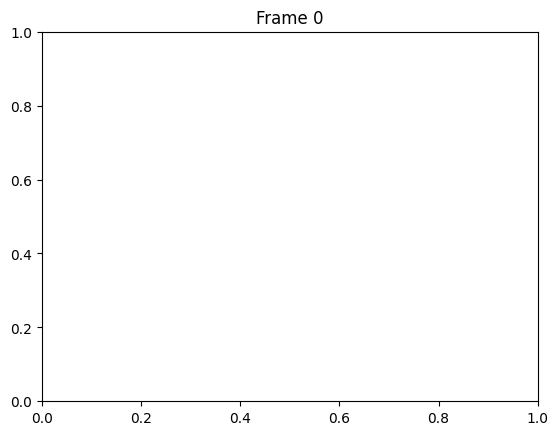

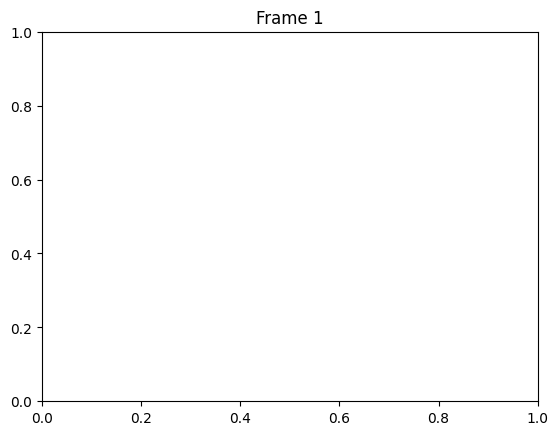

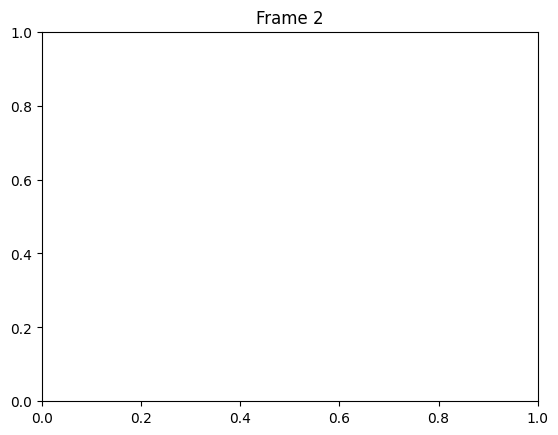

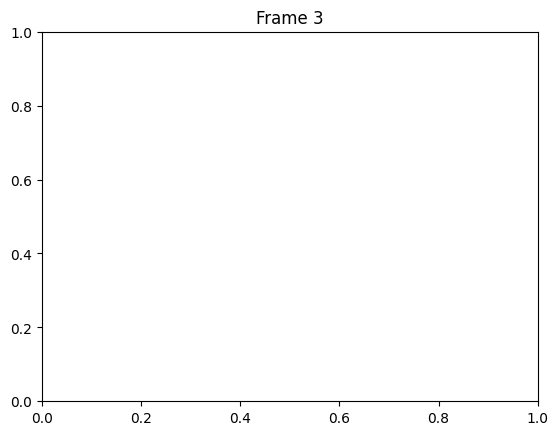

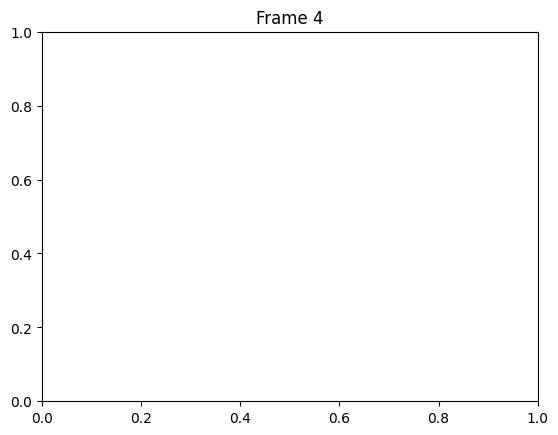

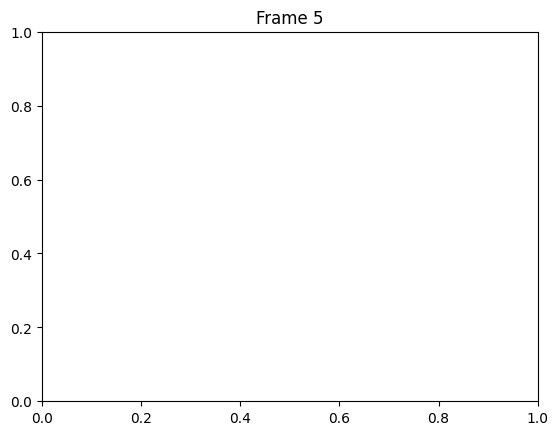

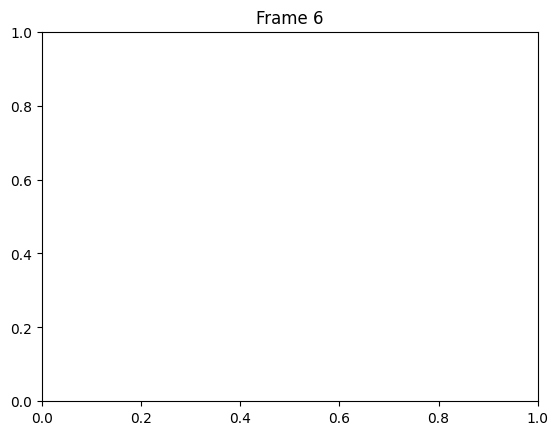

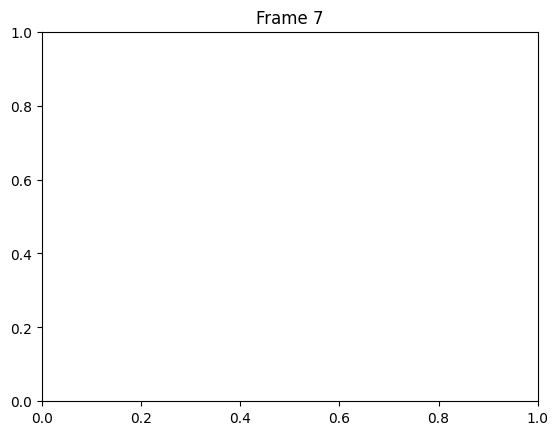

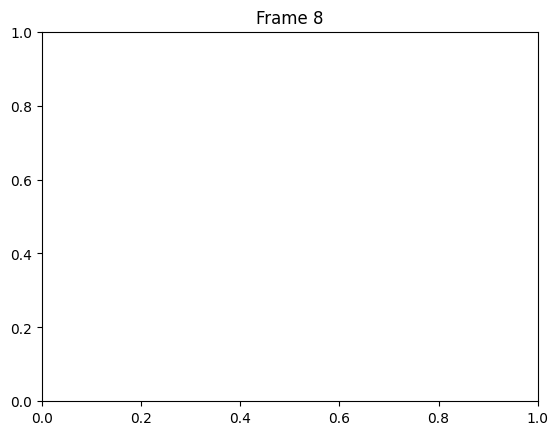

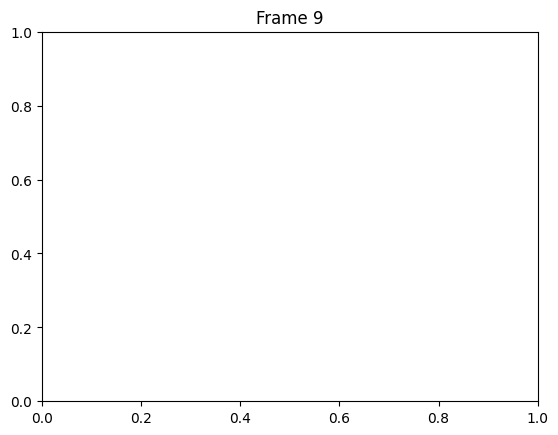

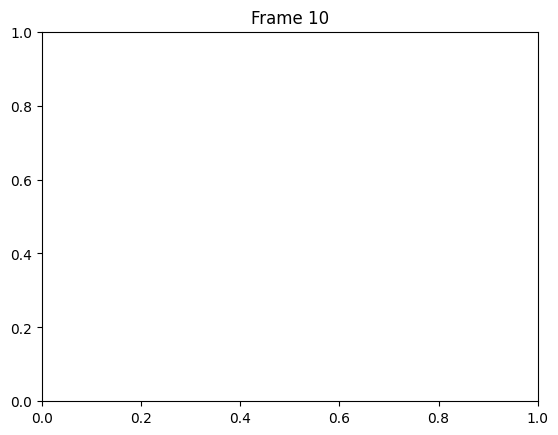

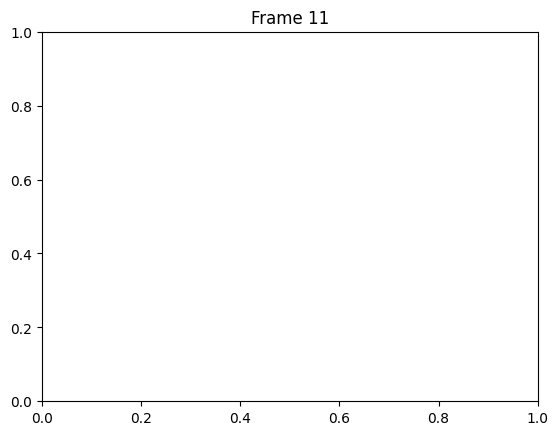

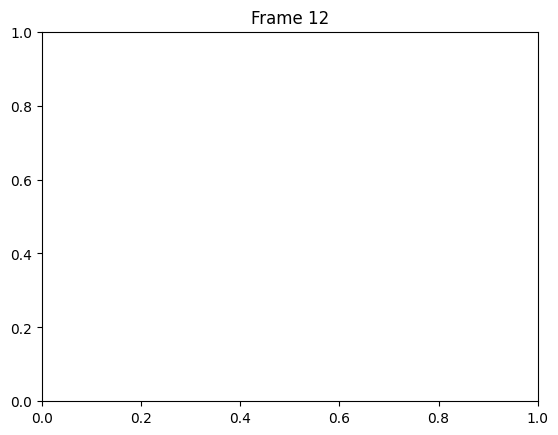

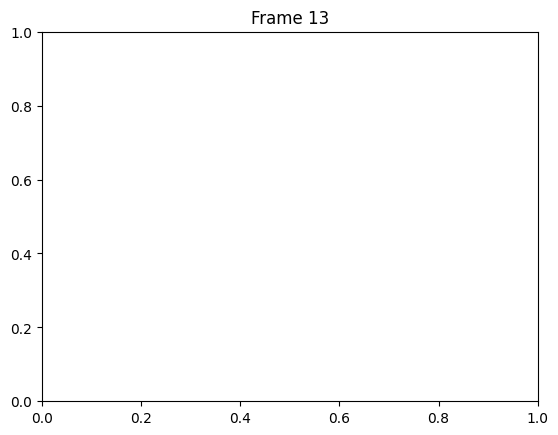

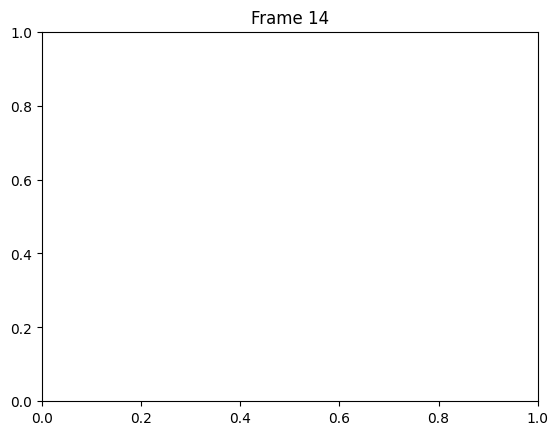

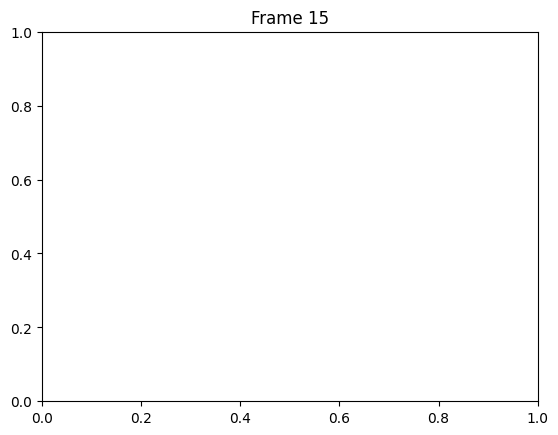

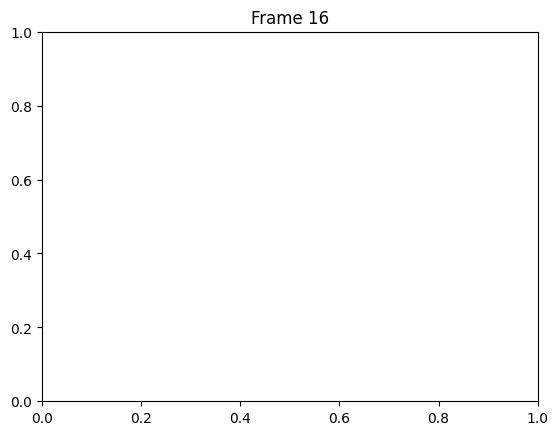

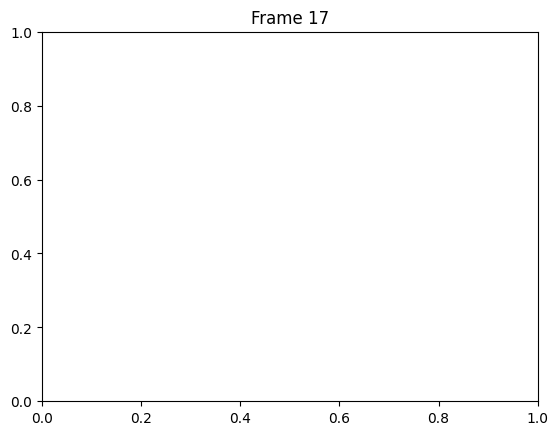

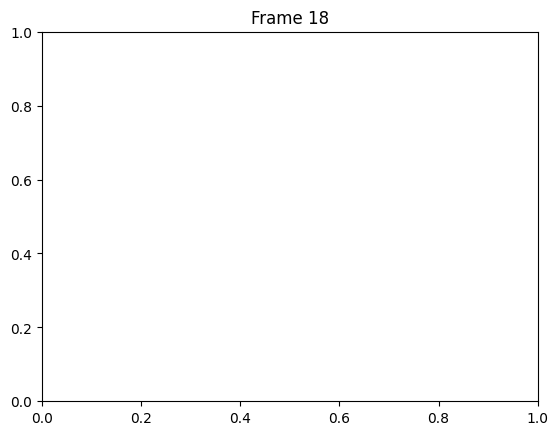

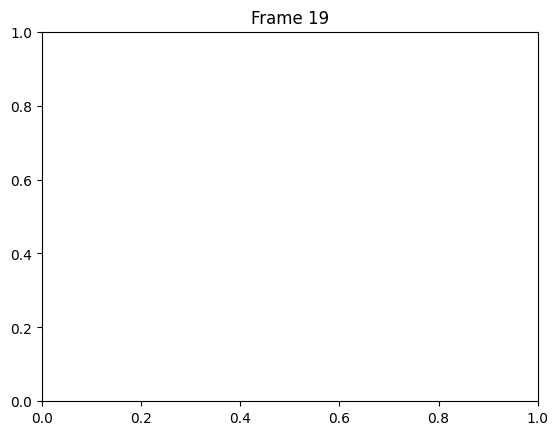

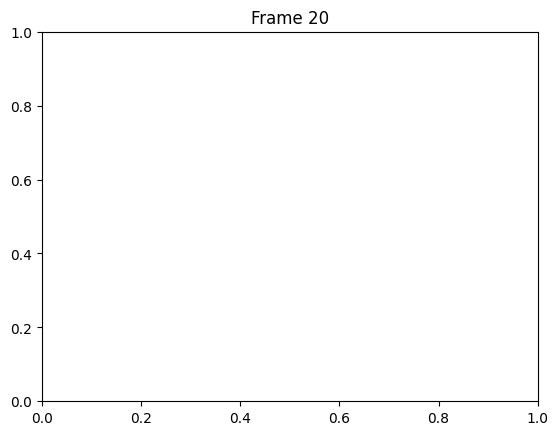

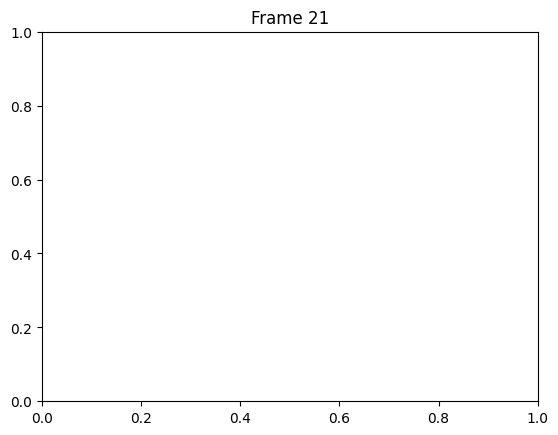

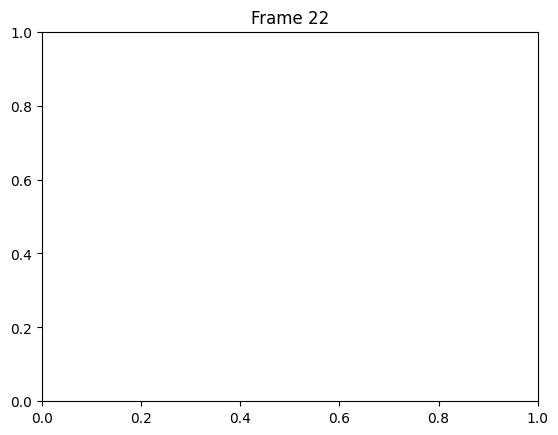

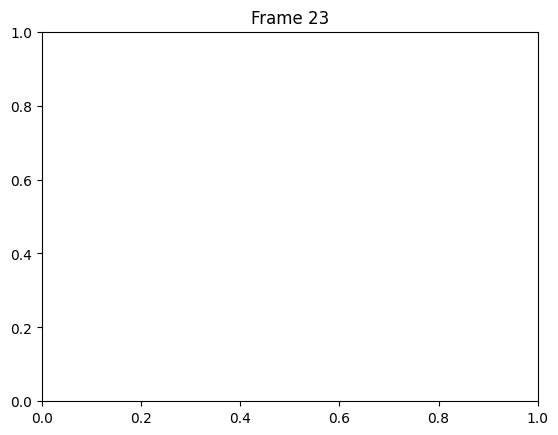

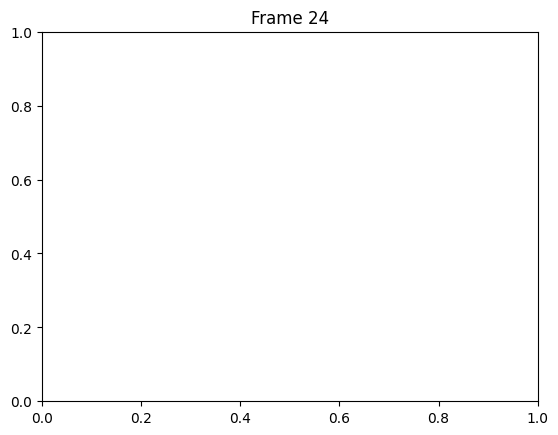

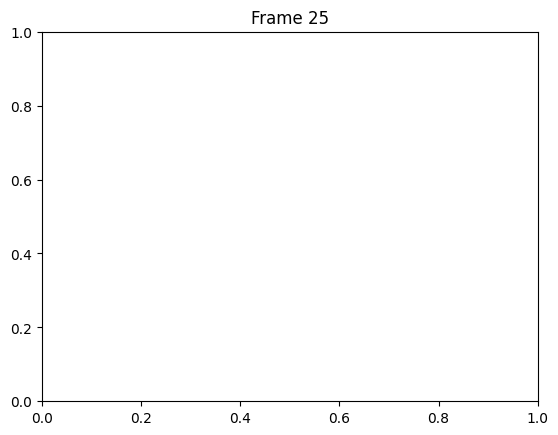

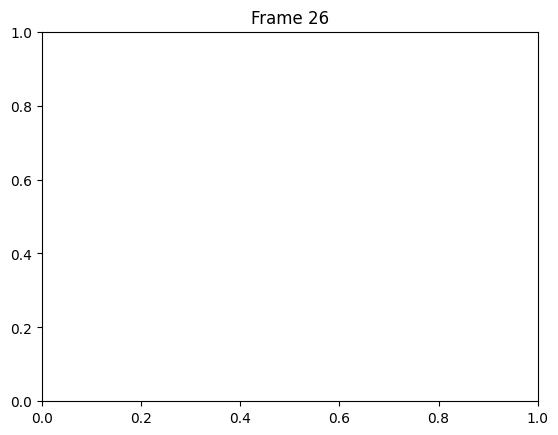

KeyboardInterrupt: 

In [439]:
num_images = 337
for i in range(num_images):
    plt.clf()  # Clear the figure to show the next image
    show_image_with_bboxes_and_scores(all_images[i], Per_Frame_Boxes[i])
    plt.title(f"Frame {i}")
    plt.pause(0.1)  # Pause briefly to create an animation-like effect

plt.show()  # Ensure the last frame stays displayed

In [440]:
num_images = 337
fps = 10
# convert to video
output_video_path = '/Users/alig/Desktop/Self Driving HW/Project/output_video_2.mp4'

# Determine frame size from the first frame
height, width, channels = all_images[0].shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

for i in range(num_images):
    # Draw bboxes on frame i
    img_with_bboxes = show_image_with_bboxes_and_scores(all_images[i], Per_Frame_Boxes[i])
    # Write the frame to the video
    out.write(img_with_bboxes)

# Release the video writer
out.release()

print(f"Video saved to {output_video_path}")

Video saved to /Users/alig/Desktop/Self Driving HW/Project/output_video_2.mp4
